In [129]:
# Useful starting lines
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [117]:
from pre_post_process import *

_, ratings = load_data("data_train.csv")
sample_ids, _ = load_data("sample_submission.csv")
print(np.shape(ratings))

number of items: 1000, number of users: 10000
number of items: 1000, number of users: 10000
(1000, 10000)


### Plot the number of ratings per movie and user

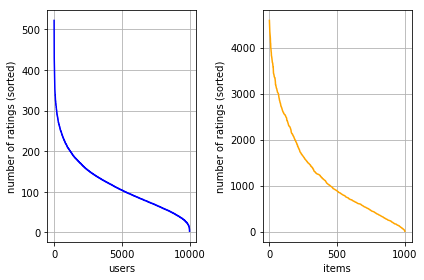

min # of items per user = 3, min # of users per item = 8.


In [4]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [106]:
valid_ratings, train, test = split_data(ratings, p_test=0.1)

the shape of original ratings. (# of row, # of col): (1000, 10000)
the shape of valid ratings. (# of row, # of col): (1000, 10000)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1068598
Total number of nonzero elements in test data:108354


### Finding parameters for SGD

In [6]:
from SGD_helpers import *

We need to find the values of the step size $\gamma$ first for a fixed value of the 3 other parameters and then compute a grid search to find the best parameters for the regularizers $\lambda_{user}$, $\lambda_{item}$ (both between 0 and 1) and the number of features $K$

In [159]:
# Finding gamma:
gammas = np.logspace(-5,0,6)
K = 50
lambda_user = 0.01
lambda_item = 0.01
num_epochs = 20
errors = []

for gamma in gammas:
    # Initialize features matrix
    user_init, item_init = init_MF(train, K)
    # Compute SGD
    _, _, rmse = matrix_factorization_SGD(train, test, gamma, K, lambda_user, lambda_item, num_epochs, user_init, item_init)
    errors.append(rmse)

Learn the matrix factorization using SGD with K = 50, lambda_i = 0.01, lambda_u = 0.01
iter: 0, RMSE on training set: 1.0254163402880199.
iter: 5, RMSE on training set: 0.9970562707025038.
iter: 10, RMSE on training set: 0.9878420873516897.
iter: 15, RMSE on training set: 0.9827800385900544.
RMSE on test data: 0.9956946199719938.
Learn the matrix factorization using SGD with K = 50, lambda_i = 0.01, lambda_u = 0.01
iter: 0, RMSE on training set: 1.0476258793239321.
iter: 5, RMSE on training set: 0.9589571948307791.
iter: 10, RMSE on training set: 0.8527435785856862.
iter: 15, RMSE on training set: 0.8095947135380929.
RMSE on test data: 1.0043973015749026.
Learn the matrix factorization using SGD with K = 50, lambda_i = 0.01, lambda_u = 0.01
iter: 0, RMSE on training set: 1.0919266199950395.
iter: 5, RMSE on training set: 0.7711472883038539.
iter: 10, RMSE on training set: 0.6921353233596186.
iter: 15, RMSE on training set: 0.6730727947086461.
RMSE on test data: 1.1173694899753186.


After many computations (not only on logspace) for same parameters for K and the 2 lambdas, we found that $\gamma = 0.025$ is the best

In [152]:
# Grid Search:
grid = np.zeros((4, 4, 4))
gamma = 0.025 # best gamma we found above
num_epochs = 20
lambdas_user = np.logspace(-3,0,4)[::-1] #From max to min
lambdas_item = np.logspace(-3,0,4)[::-1]
num_features = [20]#np.linspace(20,100,4)
min_loss = 100000
best_user_features = []
best_item_features = []

for x,K in enumerate(num_features):
    ### Warm start: directly start computation from previously computed item_features and user_features and not random initialization 
    user_init, item_init = init_MF(train, int(K))
    for y,lambda_u in enumerate(lambdas_user):
        for z,lambda_i in enumerate(lambdas_item):
            print("K = {}, lambda_u = {}, lambda_i = {}".format(int(K), lambda_u, lambda_i))
            item_feats, user_feats, rmse = matrix_factorization_SGD(train, test, gamma, int(K), lambda_u, lambda_i, num_epochs,
                                                                    user_init, item_init)
            ### For warm start, we keep the user_features and item_features that gave us the minimal rmse previously computed
            if rmse < min_loss:
                min_loss = rmse
                user_init = user_feats
                item_init = item_feats
                best_user_features = np.copy(user_feats)
                best_item_features = np.copy(item_feats)
            grid[x, y, z] = rmse

K = 20, lambda_u = 1.0, lambda_i = 1.0
Learn the matrix factorization using SGD with K = 20, lambda_i = 1.0, lambda_u = 1.0, num_epochs = 20
iter: 0, RMSE on training set: 1.4249950378246499.
iter: 5, RMSE on training set: 1.4120160645284874.
iter: 10, RMSE on training set: 1.4116068716286072.
iter: 15, RMSE on training set: 1.4077530504972702.
iter: 19, RMSE on training set: 1.409888223828191.
RMSE on test data: 1.4164969529686207.
K = 20, lambda_u = 1.0, lambda_i = 0.1
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.1, lambda_u = 1.0, num_epochs = 20
iter: 0, RMSE on training set: 1.095432153262666.
iter: 5, RMSE on training set: 1.0608482058112438.
iter: 10, RMSE on training set: 1.0468110995020465.
iter: 15, RMSE on training set: 1.0409872553950328.
iter: 19, RMSE on training set: 1.0404915029256618.
RMSE on test data: 1.0488797723925372.
K = 20, lambda_u = 1.0, lambda_i = 0.01
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.01, lambda_u = 1.0,

As showed in the following grid, we see that the minimal loss is obtained for parameters $\lambda_{user} = 0.1$ and $\lambda_{item} = 0.01$ and number of features $K = 20$ :

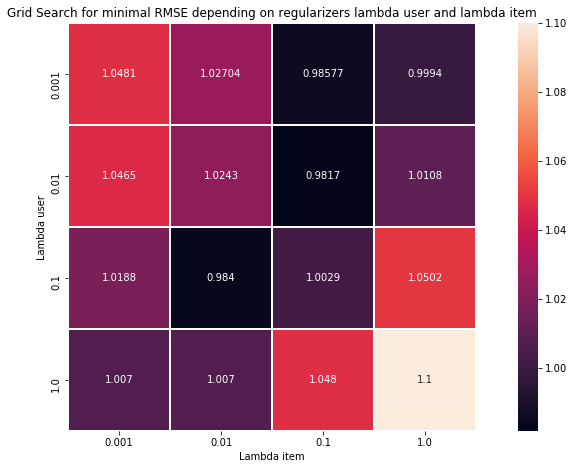

In [169]:
grid = np.matrix([[1.0481,1.02704,0.98577,0.9994],[1.0465, 1.0243, 0.9817, 1.0108],[1.0188, 0.9840, 1.0029, 1.0502],[1.007, 1.007, 1.048, 1.1]])
fig, ax = plt.subplots(figsize=(15, 7.5))
#cmap = sns.light_palette((260, 75, 60), input="husl", reverse = True)
sns.heatmap(grid, ax = ax, square = True, annot = True, linewidth = 0.5, fmt='g')
lambdas_test1 = [0.001, 0.01, 0.1, 1.0]
lambdas_test2 = [0.001, 0.01, 0.1, 1.0]
ax.set_xticklabels(lambdas_test1)
ax.set_yticklabels(lambdas_test2)
ax.set_xlabel("Lambda item")
ax.set_ylabel("Lambda user")
plt.title("Grid Search for minimal RMSE depending on regularizers lambda user and lambda item")

Run the SGD with the best parameters we found:

In [130]:
best_gamma = 0.025
best_lambda_u = 0.1
best_lambda_i = 0.01
K = 20
num_epochs = 20

user_init, item_init = init_MF(ratings, K)
item_feats_SGD, user_feats_SGD, rmse = matrix_factorization_SGD(ratings, test, best_gamma, K, best_lambda_u, best_lambda_i, num_epochs,
                                                                    user_init, item_init, include_test = True)

Learn the matrix factorization using SGD with K = 20, lambda_i = 0.01, lambda_u = 0.1, num_epochs = 20
iter: 0, RMSE on training set: 1.039015495480253.
iter: 5, RMSE on training set: 0.9526161748466169.
iter: 10, RMSE on training set: 0.9119143765305943.
iter: 15, RMSE on training set: 0.8980931229390914.
iter: 19, RMSE on training set: 0.894368802114211.
RMSE on test data: 0.894983953589312.


In [163]:
predictions = np.dot(item_feats.T, user_feats)
print("Shape of predictions (user x items): {}".format(np.shape(predictions)))

Shape of predictions (user x items): (1000, 10000)


### Adding biases

In [92]:
from bias_helpers import *

Instead of having $p_{u, i} = \mathbf{w}_i\mathbf{z^{T}}_u$ we would add bias on the user and item by having the following:
$$p_{u, i} = \mu + b_{u} + b_{i} + \mathbf{w}_i\mathbf{z^{T}}_u$$

where $\mu$ is the average of all ratings, $b_{u}$ and $b_{i}$ are the observed deviations of user u and item i respectively from the average (the biases).

Thus we now want to find the best $\mathbf{W}$ and $\mathbf{Z}$ that minimizes the loss:

$$min_{W,Z} \sum_{(u, i) \in \Omega} (r_{u,i} - \mu - b_{u} - b_{i} - \mathbf{W_{u}} \mathbf{Z^{T}_{i}}) + \lambda_{item} (||W||_{F}^{2} + b_{i}^{2}) + \lambda_{user} (||Z||_{F}^{2} + b_{u}^{2}) $$

And we need to compute the gradient of this loss. It is the same as before except we can convert our rating matrix to a biased rating matrix with ratings $r'_{u, i} = r_{u, i} - \mu - b_{u} - b_{i}$ and compute our SGD on this biased matrix

In [174]:
bias_train, mean, bias_u_train, bias_i_train = computeBiasMatrix(ratings) #ratings for final submissions
bias_test, _, _, _ = computeBiasMatrix(test)

C:\Users\olivi\Documents\semestre7\MachineLearning\ML_course\projects\project2\project_recommender_system\bias_helpers.py:27: RuntimeWarning: invalid value encountered in true_divide
  mean_items = [mean_items[i, 0] for i in range(num_items)]/nz_items
C:\Users\olivi\Documents\semestre7\MachineLearning\ML_course\projects\project2\project_recommender_system\bias_helpers.py:29: RuntimeWarning: invalid value encountered in true_divide
  bias_users = mean_users - np.ones(num_users) * mu


Compute grid search with best parameters:

In [168]:
# Grid Search:
grid = np.zeros((4, 4)) ### np.zeros((4, 4, 4))
gamma = 0.025 # best gamma we found above
num_epochs = 20
lambdas_user = np.logspace(-3,0,4)[::-1] #From max to min
lambdas_item = np.logspace(-3,0,4)[::-1]
#num_features = np.linspace(20,100,4)
K = 20
min_loss = 100000
best_user_feats = []
best_item_feats = []

### Warm start: directly start computation from previously computed item_features and user_features and not random initialization
user_init, item_init = init_MF(bias_train, K)
for x,lambda_u in enumerate(lambdas_user):
    for y,lambda_i in enumerate(lambdas_item):
        print("K = {}, lambda_u = {}, lambda_i = {}".format(int(K), lambda_u, lambda_i))
        item_feats, user_feats, rmse = matrix_factorization_SGD(bias_train, bias_test, gamma, K, lambda_u,
                                                                lambda_i, num_epochs, user_init, item_init)
        ### For warm start, we keep the user_features and item_features that gave us the minimal rmse previously computed
        if rmse < min_loss:
            print("New best")
            min_loss = rmse
            user_init = user_feats
            item_init = item_feats
            best_user_feats = np.copy(user_feats)
            best_item_feats = np.copy(item_feats)
        grid[x, y] = rmse

K = 20, lambda_u = 1.0, lambda_i = 1.0
Learn the matrix factorization using SGD with K = 20, lambda_i = 1.0, lambda_u = 1.0, num_epochs = 20
iter: 0, RMSE on training set: 0.9950116460840475.
iter: 5, RMSE on training set: 0.9950141371196208.
iter: 10, RMSE on training set: 0.9950141496724862.
iter: 15, RMSE on training set: 0.9950141514276349.
iter: 19, RMSE on training set: 0.995014151868941.
RMSE on test data: 0.9584170940125771.
New best
K = 20, lambda_u = 1.0, lambda_i = 0.1
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.1, lambda_u = 1.0, num_epochs = 20
iter: 0, RMSE on training set: 0.994964217375352.
iter: 5, RMSE on training set: 0.9950123476256876.
iter: 10, RMSE on training set: 0.9950134444785728.
iter: 15, RMSE on training set: 0.9950136363532148.
iter: 19, RMSE on training set: 0.9950136871719619.
RMSE on test data: 0.9584168616132692.
New best
K = 20, lambda_u = 1.0, lambda_i = 0.01
Learn the matrix factorization using SGD with K = 20, lambda_i = 0.0

In [175]:
# define parameters
gamma = 0.025
K = 20
lambda_user = 0.1
lambda_item = 0.01
num_epochs = 50
user_init, item_init = init_MF(bias_train, K)

item_featuresSGD, user_featuresSGD, rmse = matrix_factorization_SGD(bias_train, bias_test, gamma, K, lambda_user,
                                                              lambda_item, num_epochs, user_init, item_init, include_test = False)

Learn the matrix factorization using SGD with K = 20, lambda_i = 0.01, lambda_u = 0.1, num_epochs = 50
iter: 0, RMSE on training set: 0.9948057147421926.
iter: 5, RMSE on training set: 0.9718694556686884.
iter: 10, RMSE on training set: 0.9483473151299702.
iter: 15, RMSE on training set: 0.9344269708524305.
iter: 20, RMSE on training set: 0.9283302072018155.
iter: 25, RMSE on training set: 0.9258515942108939.
iter: 30, RMSE on training set: 0.9248543886148187.
iter: 35, RMSE on training set: 0.9244536756901859.
iter: 40, RMSE on training set: 0.924292657134911.
iter: 45, RMSE on training set: 0.9242279517059699.
iter: 49, RMSE on training set: 0.9242054430662141.


Compute the predictions:

In [170]:
# Compute predictions matrix from the biases, item and user features computed with SGD
predictions = predictionsWithBias(best_item_feats, best_user_feats, bias_u_train, bias_i_train, mean)
print("Shape of predictions (user x items): {}".format(np.shape(predictions)))

Shape of predictions (user x items): (1000, 10000)


In [171]:
### Checking if results appear the same in the final excel file
first_user, first_item = sample_ids[0][0],sample_ids[0][1]
print(first_item, first_user)
print(predictions[first_user - 1, first_item - 1])

1 37
3.9243063502


### Submission

Make sure to set the ratings above 5.0 to 5.0 and those below 1.0 to 1.0

In [172]:
predictions[ np.where( predictions > 5.0 ) ] = 5.0
predictions[ np.where(predictions < 1.0)] = 1.0
print("Minimum prediction: {}, Maximum prediction: {}".format(np.min(predictions), np.max(predictions)))

Minimum prediction: 1.0, Maximum prediction: 5.0


In [173]:
print("Shape of predictions (user x items): {}".format(np.shape(predictions)))
wanted_preds = getWantedPredictions(predictions.T, sample_ids)
create_csv_submission(sample_ids, wanted_preds, "submissions/bias_training_gridsearch_not_warm.csv")

Shape of predictions (user x items): (1000, 10000)
